In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from torch.utils.data import Dataset, DataLoader, Subset

In [2]:
def set_seed(seed=7):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # ensure deterministic behavior on GPU
    torch.backends.cudnn.deterministic = True
    # allow some optimizations for deterministic behavior
    torch.backends.cudnn.benchmark = False

set_seed()

In [3]:
class nconv(nn.Module):
    def __init__(self):
        super(nconv,self).__init__()

    def forward(self, x, A):
        # x: (batch, channels, nodes, time), A: (nodes, nodes)
        x = torch.einsum('ncwl,vw->ncvl',(x,A))
        return x.contiguous()

class dy_nconv(nn.Module):
    def __init__(self):
        super(dy_nconv,self).__init__()

    def forward(self,x, A):
        # x: (batch, channels, nodes, time), A: (batch, nodes, nodes, time?), here we keep as is from original code
        x = torch.einsum('ncvl,nvwl->ncwl',(x,A))
        return x.contiguous()

class linear(nn.Module):
    def __init__(self,c_in,c_out,bias=True):
        super(linear,self).__init__()
        self.mlp = torch.nn.Conv2d(c_in, c_out, kernel_size=(1, 1), bias=bias)

    def forward(self,x):
        return self.mlp(x)

class mixprop(nn.Module):
    def __init__(self,c_in,c_out,gdep,dropout,alpha):
        super(mixprop, self).__init__()
        self.nconv = nconv()
        self.mlp = linear((gdep+1)*c_in,c_out)
        self.gdep = gdep
        self.dropout = dropout
        self.alpha = alpha

    def forward(self,x,adj):
        adj = adj + torch.eye(adj.size(0)).to(x.device)
        d = adj.sum(1)
        h = x
        out = [h]
        a = adj / d.view(-1, 1)
        for i in range(self.gdep):
            h = self.alpha*x + (1-self.alpha)*self.nconv(h,a)
            out.append(h)
        ho = torch.cat(out,dim=1)
        ho = self.mlp(ho)
        return ho

class dilated_inception(nn.Module):
    def __init__(self, cin, cout, dilation_factor=2):
        super(dilated_inception, self).__init__()
        self.tconv = nn.ModuleList()
        self.kernel_set = [2,3,6,7]
        cout = int(cout/len(self.kernel_set))
        for kern in self.kernel_set:
            self.tconv.append(nn.Conv2d(cin,cout,(1,kern),dilation=(1,dilation_factor)))

    def forward(self,input):
        x = []
        for conv in self.tconv:
            x.append(conv(input))
        # align last dimension
        min_time = min([xx.size(3) for xx in x])
        x = [xx[:,:,:, -min_time:] for xx in x]
        x = torch.cat(x,dim=1)
        return x

class graph_constructor(nn.Module):
    def __init__(self, nnodes, k, dim, device, alpha=3, static_feat=None):
        super(graph_constructor, self).__init__()
        self.nnodes = nnodes
        if static_feat is not None:
            xd = static_feat.shape[1]
            self.lin1 = nn.Linear(xd, dim)
            self.lin2 = nn.Linear(xd, dim)
        else:
            self.emb1 = nn.Embedding(nnodes, dim)
            self.emb2 = nn.Embedding(nnodes, dim)
            self.lin1 = nn.Linear(dim,dim)
            self.lin2 = nn.Linear(dim,dim)

        self.device = device
        self.k = k
        self.dim = dim
        self.alpha = alpha
        self.static_feat = static_feat

    def forward(self, idx):
        if self.static_feat is None:
            nodevec1 = self.emb1(idx)
            nodevec2 = self.emb2(idx)
        else:
            nodevec1 = self.static_feat[idx,:]
            nodevec2 = nodevec1

        nodevec1 = torch.tanh(self.alpha*self.lin1(nodevec1))
        nodevec2 = torch.tanh(self.alpha*self.lin2(nodevec2))

        a = torch.mm(nodevec1, nodevec2.transpose(1,0))-torch.mm(nodevec2, nodevec1.transpose(1,0))
        adj = F.relu(torch.tanh(self.alpha*a))
        mask = torch.zeros(idx.size(0), idx.size(0)).to(self.device)
        mask.fill_(0.0)
        s1,t1 = (adj + torch.rand_like(adj)*0.01).topk(self.k,1)
        mask.scatter_(1,t1,s1.fill_(1))
        adj = adj*mask
        return adj

class LayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5, elementwise_affine=True):
        super(LayerNorm, self).__init__()
        if isinstance(normalized_shape, int):
            normalized_shape = (normalized_shape,)
        self.normalized_shape = tuple(normalized_shape)
        self.eps = eps
        self.elementwise_affine = elementwise_affine
        if self.elementwise_affine:
            self.weight = nn.Parameter(torch.Tensor(*normalized_shape))
            self.bias = nn.Parameter(torch.Tensor(*normalized_shape))
        else:
            self.register_parameter('weight', None)
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        if self.elementwise_affine:
            nn.init.ones_(self.weight)
            nn.init.zeros_(self.bias)

    def forward(self, input, idx):
        if self.elementwise_affine:
            return F.layer_norm(input, input.shape[1:], self.weight[:, idx, :], self.bias[:, idx, :], self.eps)
        else:
            return F.layer_norm(input, input.shape[1:], None, None, self.eps)

In [4]:
class gtnet(nn.Module):
    def __init__(self, gcn_true, buildA_true, gcn_depth, num_nodes, device, predefined_A=None, static_feat=None, 
                 dropout=0.3, subgraph_size=20, node_dim=40, dilation_exponential=1, conv_channels=32, 
                 residual_channels=32, skip_channels=64, end_channels=128, seq_length=12, in_dim=1, out_dim=3, 
                 layers=3, propalpha=0.05, tanhalpha=3, layer_norm_affline=True):
        super(gtnet, self).__init__()
        self.gcn_true = gcn_true
        self.buildA_true = buildA_true
        self.num_nodes = num_nodes
        self.dropout = dropout
        self.predefined_A = predefined_A
        self.filter_convs = nn.ModuleList()
        self.gate_convs = nn.ModuleList()
        self.residual_convs = nn.ModuleList()
        self.skip_convs = nn.ModuleList()
        self.gconv1 = nn.ModuleList()
        self.gconv2 = nn.ModuleList()
        self.norm = nn.ModuleList()
        self.gc = graph_constructor(num_nodes, subgraph_size, node_dim, device, alpha=tanhalpha, static_feat=static_feat)
        self.seq_length = seq_length
        kernel_size = 7
        if dilation_exponential>1:
            self.receptive_field = int(1+(kernel_size-1)(dilation_exponential*layers-1)/(dilation_exponential-1))
        else:
            self.receptive_field = layers*(kernel_size-1) + 1

        self.start_conv = nn.Conv2d(in_channels=in_dim, out_channels=residual_channels, kernel_size=(1, 1))

        # building layers
        for i in range(1):
            if dilation_exponential>1:
                rf_size_i = int(1 + i*(kernel_size-1)(dilation_exponential*layers-1)/(dilation_exponential-1))
            else:
                rf_size_i = i*layers*(kernel_size-1)+1
            new_dilation = 1
            for j in range(1,layers+1):
                if dilation_exponential > 1:
                    rf_size_j = int(rf_size_i + (kernel_size-1)(dilation_exponential*j-1)/(dilation_exponential-1))
                else:
                    rf_size_j = rf_size_i+j*(kernel_size-1)

                self.filter_convs.append(dilated_inception(residual_channels, conv_channels, dilation_factor=new_dilation))
                self.gate_convs.append(dilated_inception(residual_channels, conv_channels, dilation_factor=new_dilation))
                self.residual_convs.append(nn.Conv2d(in_channels=conv_channels,
                                                     out_channels=residual_channels,
                                                     kernel_size=(1, 1)))
                if self.seq_length>self.receptive_field:
                    self.skip_convs.append(nn.Conv2d(in_channels=conv_channels,
                                                     out_channels=skip_channels,
                                                     kernel_size=(1, self.seq_length-rf_size_j+1)))
                else:
                    self.skip_convs.append(nn.Conv2d(in_channels=conv_channels,
                                                     out_channels=skip_channels,
                                                     kernel_size=(1, self.receptive_field-rf_size_j+1)))
                if self.gcn_true:
                    self.gconv1.append(mixprop(conv_channels, residual_channels, gcn_depth, dropout, propalpha))
                    self.gconv2.append(mixprop(conv_channels, residual_channels, gcn_depth, dropout, propalpha))

                if self.seq_length>self.receptive_field:
                    self.norm.append(LayerNorm((residual_channels, num_nodes, self.seq_length - rf_size_j + 1),
                                               elementwise_affine=layer_norm_affline))
                else:
                    self.norm.append(LayerNorm((residual_channels, num_nodes, self.receptive_field - rf_size_j + 1),
                                               elementwise_affine=layer_norm_affline))

                new_dilation *= dilation_exponential

        self.layers = layers

        # skip0, skipE for last skip connections
        if self.seq_length > self.receptive_field:
            self.skip0 = nn.Conv2d(in_channels=in_dim, out_channels=skip_channels, kernel_size=(1, self.seq_length), bias=True)
            self.skipE = nn.Conv2d(in_channels=residual_channels, out_channels=skip_channels,
                                   kernel_size=(1, self.seq_length - self.receptive_field + 1), bias=True)
        else:
            self.skip0 = nn.Conv2d(in_channels=in_dim, out_channels=skip_channels, kernel_size=(1, self.receptive_field), bias=True)
            self.skipE = nn.Conv2d(in_channels=residual_channels, out_channels=skip_channels, kernel_size=(1,1), bias=True)

        # final layers for classification: we now output out_dim classes
        self.end_conv_1 = nn.Conv2d(in_channels=skip_channels,
                                    out_channels=end_channels,
                                    kernel_size=(1,1),
                                    bias=True)
        self.end_conv_2 = nn.Conv2d(in_channels=end_channels,
                                    out_channels=out_dim,
                                    kernel_size=(1,1),
                                    bias=True)

        self.idx = torch.arange(self.num_nodes).to(device)

    def forward(self, input, idx=None):
        # input: (batch, in_dim, nodes, seq_length)
        seq_len = input.size(3)
        assert seq_len==self.seq_length, 'Input sequence length not equal to preset sequence length'

        if self.seq_length<self.receptive_field:
            input = nn.functional.pad(input,(self.receptive_field-self.seq_length,0,0,0))

        # build adjacency if needed
        if self.gcn_true:
            if self.buildA_true:
                if idx is None:
                    adp = self.gc(self.idx)
                else:
                    adp = self.gc(idx)
            else:
                adp = self.predefined_A

        x = self.start_conv(input)
        skip = self.skip0(F.dropout(input, self.dropout, training=self.training))
        for i in range(self.layers):
            residual = x
            filter = self.filter_convs[i](x)
            filter = torch.tanh(filter)
            gate = self.gate_convs[i](x)
            gate = torch.sigmoid(gate)
            x = filter * gate
            x = F.dropout(x, self.dropout, training=self.training)
            s = x
            s = self.skip_convs[i](s)
            skip = s + skip
            if self.gcn_true:
                x = self.gconv1[i](x, adp)+self.gconv2[i](x, adp.transpose(1,0))
            else:
                x = self.residual_convs[i](x)

            x = x + residual[:, :, :, -x.size(3):]
            if idx is None:
                x = self.norm[i](x,self.idx)
            else:
                x = self.norm[i](x,idx)

        skip = self.skipE(x) + skip
        x = F.relu(skip)
        x = F.relu(self.end_conv_1(x))
        x = self.end_conv_2(x)
        # x shape now: (batch, out_dim, nodes, T_out=1 or so)

        # for classification, we pool over nodes and time to get a single vector per sample
        # x: (B, out_dim, N, T). Let's pool:
        x = x.mean(dim=[2,3]) # (B, out_dim)
        return x

In [5]:
class ClassificationDataset(Dataset):
    def __init__(self, data, seq_length, num_nodes, in_dim=1, label_col=-1):
        self.seq_length = seq_length
        self.num_nodes = num_nodes
        self.in_dim = in_dim
        self.features = data[:, :40]
        self.labels = data[:, label_col].astype(int)

        self.samples = []
        total_features = self.features.shape[1]
        assert total_features == self.num_nodes * self.in_dim, 'Check feature count, num_nodes and in_dim'
        for i in range(len(self.features)-seq_length):
            x_seq = self.features[i:i+seq_length, :]  # shape (seq_length, total_features)
            y_label = self.labels[i+seq_length-1] 
            self.samples.append((x_seq, y_label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x_seq, y_label = self.samples[idx]
        # Reshape to (in_dim, num_nodes, seq_length)
        # Currently x_seq: (seq_length, total_features)
        # We want: (batch, in_dim, num_nodes, seq_length), 
        # but here just do (in_dim, num_nodes, seq_length) per sample
        x_seq = x_seq.T.reshape(self.in_dim, self.num_nodes, self.seq_length)
        x_seq = torch.tensor(x_seq, dtype=torch.float32)
        y_label = torch.tensor(y_label, dtype=torch.long)
        return x_seq, y_label

In [6]:
def undersample(data, label_col):
    label_column = data[:, label_col].astype(int)
    unique, counts = np.unique(label_column, return_counts=True)

    min_count = counts.min()

    keep_indices = []
    for label in unique:
        label_indices = np.where(label_column == label)[0]
        
        selected_indices = np.random.choice(label_indices, size=min_count, replace=False)
        
        keep_indices.extend(sorted(selected_indices))

    # sort to keep order
    keep_indices = sorted(keep_indices)
    return data[keep_indices]

In [7]:
def evaluate(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, Y in loader:
            X, Y = X.to(device), Y.to(device)
            out = model(X) # (batch, num_classes)
            pred = out.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(Y.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_preds, average=None)
    
    conf_matrix = confusion_matrix(all_labels, all_preds)
    normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    accuracy = (all_preds == all_labels).sum() / len(all_labels)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support,
        'confusion_matrix': conf_matrix,
        'normalized_confusion_matrix': normalized_conf_matrix,
    }

In [8]:
config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'train_csv': '/kaggle/input/fi2010-v2/train.csv',
    'test_csv': '/kaggle/input/fi2010-v2/test.csv',
    'num_nodes': 40,
    'seq_length': 10, # modified
    'in_dim': 1,
    'gcn_true': True,
    'buildA_true': True,
    'gcn_depth': 2,
    'dropout': 0.3,
    'subgraph_size': 20,
    'node_dim': 40, # modified
    'dilation_exponential': 1,
    'conv_channels': 32,
    'residual_channels': 32,
    'skip_channels': 64,
    'end_channels': 128,
    'out_dim': 3, # modified
    'layers': 3,
    'propalpha': 0.05,
    'tanhalpha': 3,
    'batch_size': 32,
    'epochs': 15, # modified
    'lr': 0.001,
    'weight_decay': 0.0001,
}

In [9]:
device = torch.device(config['device'])

In [10]:
label_col = -1

In [11]:
train_full = np.loadtxt(config['train_csv'], delimiter=',')
# train_ratio = 0.8
# train_size = int(len(train_full) * train_ratio)

In [12]:
# train_data = train_full[:train_size, :]
# train_data = undersample(train_data, label_col)
# val_data = train_full[train_size:, :]

In [13]:
train_dataset = ClassificationDataset(
    train_full, 
    config['seq_length'], 
    config['num_nodes'], 
    config['in_dim'], 
    label_col, 
)

In [14]:
# val_dataset = ClassificationDataset(
#     val_data, 
#     config['seq_length'], 
#     config['num_nodes'], 
#     config['in_dim'], 
#     label_col, 
# )

In [15]:
weighting = True

In [16]:
if weighting:
    classes, class_counts = np.unique(train_dataset.labels, return_counts=True)
    class_weights = torch.tensor(
        len(train_dataset.labels) / (len(classes) * class_counts), dtype=torch.float32
    )
else:
    class_weights = torch.tensor([1.0, 1.0, 1.0], dtype=torch.float32)
class_weights

tensor([0.8207, 1.7177, 0.8338])

In [17]:
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

In [18]:
model = gtnet(
    gcn_true=config['gcn_true'], 
    buildA_true=config['buildA_true'], 
    gcn_depth=config['gcn_depth'],
    num_nodes=config['num_nodes'], 
    device=device, 
    predefined_A=None, 
    static_feat=None, 
    dropout=config['dropout'], 
    subgraph_size=config['subgraph_size'], 
    node_dim=config['node_dim'], 
    dilation_exponential=config['dilation_exponential'], 
    conv_channels=config['conv_channels'], 
    residual_channels=config['residual_channels'], 
    skip_channels=config['skip_channels'], 
    end_channels=config['end_channels'], 
    seq_length=config['seq_length'], 
    in_dim=config['in_dim'], 
    out_dim=config['out_dim'], 
    layers=config['layers'], 
    propalpha=config['propalpha'], 
    tanhalpha=config['tanhalpha'], 
    layer_norm_affline=True
).to(device)

In [19]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

print('Start training...')
for epoch in range(config['epochs']):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for X, Y in train_loader:
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        out = model(X) # (batch, out_dim)
        loss = criterion(out, Y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += pred.eq(Y).sum().item()
        total += Y.size(0)
    # stats = evaluate(model, val_loader, device)
    # print(f"Epoch {epoch+1}/{config['epochs']}, Loss: {total_loss/len(train_loader):.4f}, Val F1: {np.mean(stats['f1']):.4f}")
    print(f"Epoch {epoch+1}/{config['epochs']}, Loss: {total_loss/len(train_loader):.4f}")

Start training...
Epoch 1/15, Loss: 0.8558
Epoch 2/15, Loss: 0.7357
Epoch 3/15, Loss: 0.6996
Epoch 4/15, Loss: 0.6771
Epoch 5/15, Loss: 0.6481
Epoch 6/15, Loss: 0.6182
Epoch 7/15, Loss: 0.5983
Epoch 8/15, Loss: 0.5839
Epoch 9/15, Loss: 0.5734
Epoch 10/15, Loss: 0.5659
Epoch 11/15, Loss: 0.5595
Epoch 12/15, Loss: 0.5559
Epoch 13/15, Loss: 0.5502
Epoch 14/15, Loss: 0.5472
Epoch 15/15, Loss: 0.5439


In [20]:
test_data = np.loadtxt(config['test_csv'], delimiter=',')

In [21]:
test_dataset = ClassificationDataset(
    test_data, 
    config['seq_length'], 
    config['num_nodes'], 
    config['in_dim'], 
    label_col, 
)

In [22]:
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

In [23]:
stats = evaluate(model, test_loader, device)

In [24]:
stats['accuracy']

0.8097250979745947

In [25]:
def plt_confusion_matrix(conf_mat):
    class_names = ['down', 'stationary', 'up']
    
    plt.figure(figsize=(4, 4))
    sns.heatmap(
        conf_mat, annot=True, fmt='.2f', cmap='Greens', 
        xticklabels=class_names, yticklabels=class_names, 
        cbar=False, vmin=0, vmax=1
    )
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.savefig('confusion_matrix.pdf', format='pdf', bbox_inches='tight')
    plt.show()

In [26]:
def plt_f1_vs_windows(windows, f1_dict):
    plt.figure(figsize=(4.5, 4.5))

    colors = {
        'macro': 'black',
        'down': 'red',
        'stationary': 'dodgerblue',
        'up': 'green'
    }

    for label, f1s in f1_dict.items():
        plt.plot(
            windows, f1s, 
            marker='o', 
            linestyle='dashed' if label != 'macro' else 'solid', 
            label=label, 
            color=colors[label],
            linewidth=1.5 if label != 'macro' else 3, 
            zorder=3 if label == 'macro' else 2
        )
    
    plt.title('F1 Score vs Window Size')
    plt.xlabel('Window Size')
    plt.xticks(windows)
    plt.ylabel('F1 Score')
    plt.grid(True)
    plt.legend()
    plt.savefig('f1_window_size.pdf', format='pdf', bbox_inches='tight')
    plt.show()

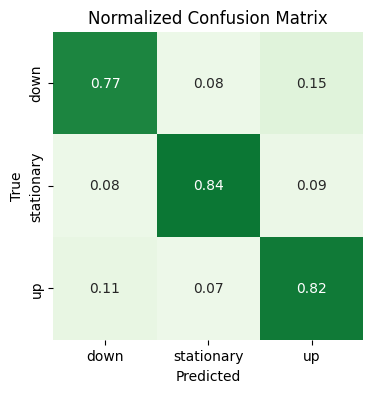

In [27]:
plt_confusion_matrix(stats['normalized_confusion_matrix'])

In [28]:
stats['f1']

array([0.79554214, 0.84381961, 0.78852651])

In [29]:
np.mean(stats['f1'])

0.8092960857464693

In [30]:
stats

{'accuracy': 0.8097250979745947,
 'precision': array([0.81781564, 0.85212852, 0.75941561]),
 'recall': array([0.77444972, 0.83567118, 0.81995821]),
 'f1': array([0.79554214, 0.84381961, 0.78852651]),
 'support': array([47976, 48050, 43551]),
 'confusion_matrix': array([[37155,  3759,  7062],
        [ 3645, 40154,  4251],
        [ 4632,  3209, 35710]]),
 'normalized_confusion_matrix': array([[0.77444972, 0.07835168, 0.1471986 ],
        [0.07585848, 0.83567118, 0.08847034],
        [0.10635806, 0.07368373, 0.81995821]])}